In [1]:
!pip install yfinance


In [2]:
#Import libraries and fetch the dataset
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fetch Tesla stock prices from Yahoo Finance
tesla = yf.download('TSLA', start='2015-01-01', end='2021-09-30')


[*********************100%***********************]  1 of 1 completed


In [3]:
#Perform feature engineering using moving averages
# Add 10-day and 50-day moving averages
tesla['SMA10'] = tesla['Close'].rolling(window=10).mean()
tesla['SMA50'] = tesla['Close'].rolling(window=50).mean()

# Drop NaN values
tesla.dropna(inplace=True)


In [4]:
#Prepare the training and testing datasets

# Select features and target
features = ['Close', 'SMA10', 'SMA50']
target = 'Close'

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tesla[features].values)

# Prepare training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create input and output sequences
def create_sequences(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Create input and output sequences
look_back = 60
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)


In [5]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
40/40 [==============================] - 7s 37ms/step - loss: 4.5359e-04
Epoch 2/20
40/40 [==============================] - 1s 37ms/step - loss: 9.5729e-05
Epoch 3/20
40/40 [==============================] - 1s 36ms/step - loss: 8.0249e-05
Epoch 4/20
40/40 [==============================] - 1s 36ms/step - loss: 6.7171e-05
Epoch 5/20
40/40 [==============================] - 2s 38ms/step - loss: 6.9689e-05
Epoch 6/20
40/40 [==============================] - 1s 36ms/step - loss: 5.5684e-05
Epoch 7/20
40/40 [==============================] - 1s 36ms/step - loss: 6.1098e-05
Epoch 8/20
40/40 [==============================] - 2s 41ms/step - loss: 4.6448e-05
Epoch 9/20
40/40 [==============================] - 2s 52ms/step - loss: 4.2992e-05
Epoch 10/20
40/40 [==============================] - 2s 56ms/step - loss: 3.6765e-05
Epoch 11/20
40/40 [==============================] - 2s 55ms/step - loss: 3.4826e-05
Epoch 12/20
40/40 [==============================] - 1s 37ms/step - loss: 

In [6]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert scaling
train_predict = scaler.inverse_transform(np.hstack((train_predict, train_data[look_back:, 1:])))
test_predict = scaler.inverse_transform(np.hstack((test_predict, test_data[look_back:, 1:])))

# Calculate root mean squared error
train_rmse = np.sqrt(mean_squared_error(tesla['Close'][look_back:train_size], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(tesla['Close'][train_size+look_back:], test_predict[:, 0]))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


9/9 [==============================] - 0s 14ms/step
Train RMSE: 1.5086770302330508
Test RMSE: 21.173674233433733


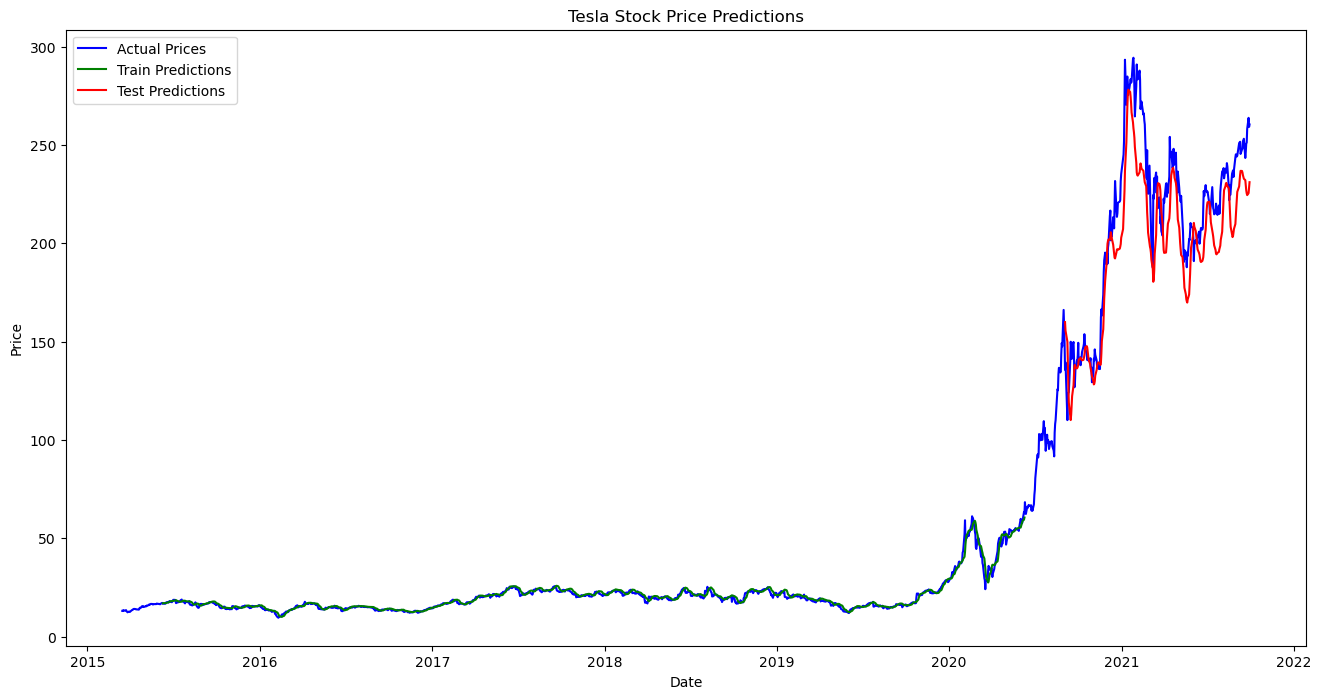

In [7]:
# Plot actual vs. predicted prices
plt.figure(figsize=(16, 8))
plt.plot(tesla.index, tesla['Close'], label='Actual Prices', color='blue')
plt.plot(tesla.index[look_back:train_size], train_predict[:, 0], label='Train Predictions', color='green')
plt.plot(tesla.index[train_size+look_back:], test_predict[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tesla Stock Price Predictions')
plt.legend()
plt.savefig('Tesla Stock Price Predictions.png')
plt.show()
